In [4]:
# Importing libraries

import numpy as np;
import matplotlib.pyplot as maps
from tqdm import tqdm
import random
from matplotlib import gridspec

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

## Physical constraints
Before proceeding, let's set the spatial and temporal domains. We have to have a minimum velocity to comply with the CPL criterion and even a maximum velocity to limit the numerical dispersion.<br /> 
We will have <br />
dx= 1.0 m <br />
epl= 0.8 <br />
and c $\in$ [200.0, 500.0] m/s <br />
Therefore, dt= epl/c_min\* dx= 0.8/200.\*1.0= 0.004 sec
<br/> Also, a 4- or 5-point FD operator would be a better choice.

## Computational constraints
There are no constraints related to physical system now. The other thing is how much data can we generate and adequately train. <br/>
If we have nx= 1001, then all the input velocity models would be of this length and so for a 100,000 data points we will have $2 * 10^8$ values corresponding to data of 1600 MB. Also, for each model, we will have, say, nt= 1000 points. That will require another 1600 GB. <br/> Something not really feasible. 
<br/> The better approach would then be to have both the velocity model as well as the amplitude in the input, that is we will have a data of 1600 MB corresponding feeding into the input nodes. This will enable us to use our model in loop to iterate for further timesteps.
<br/>We can also reduce nt to say, 10. This would make it to 8 GB. A good improvement. A reduction in number of data points to 10,000 would fit all the data within 1 GB.

## Dataset Generation

In [5]:
# Parameter Configuration 
# -----------------------

nx   = 1001        # number of grid points in x-direction
xmax = 1000        # physical domain (m)
dx   = xmax/(nx-1)  # grid point distance in x-direction
x    = dx* np.arange(nx); # spatial fabric


# Medium velocity
c_min= 200.;
c_max= 500.;
c0   = 334.         # wave speed in medium (m/s)
c    = np.zeros(nx)
c    = c + c0       # Homogeneous medium

#c[int(nx/3):int(2*nx/3)]= 0.5*c0
#c[int(nx/2):int(2*nx/3)]= 0.25* c0

# CPL Stability Criterion
eps= 0.8; # <1
dt= eps/c0*dx; # Now we don't have to worry about the stability of the solution
nt   = 500          # maximum number of time steps
time = np.linspace(0 * dt, nt * dt, nt); # time fabric

print('dt= ', dt);
print('Duration of simulation would be ', time[-1], ' sec');

dt=  0.0023952095808383233
Duration of simulation would be  1.1976047904191616  sec


In [6]:
def space(x, cmax, cmin, dist_type= 'uniform', narrow_limit= 0.15):
  l= len(x);
  nl= int(narrow_limit*l);
  if dist_type== 'uniform':
    cout= (cmax+ cmin)/2* np.ones_like(x);
  elif dist_type== '2 parts':
    c1= random.randint(cmin, cmax);
    c2= random.randint(cmin, cmax);
    b1= random.randint(int(0.3333* l), int(0.667*l));
    cout= c1*np.ones_like(x);
    cout[b1:l]= c2;
  elif dist_type== '3 parts':
    c1= random.randint(cmin, cmax);
    c2= random.randint(cmin, cmax);
    c3= random.randint(cmin, cmax);
    b1= random.randint(int(0.25* l), int(0.5*l));
    b2= random.randint(b1, int(0.75*l));
    if b2-b1<nl:
      b2= b1+nl;
    cout= c1*np.ones_like(x);
    cout[b1:b2]= c2;
    cout[b2:l]= c3;
  elif dist_type== '4 parts':
    c1= random.randint(cmin, cmax);
    c2= random.randint(cmin, cmax);
    c3= random.randint(cmin, cmax);
    c4= random.randint(cmin, cmax);
    b1= random.randint(int(0.2* l), int(0.4*l));
    b2= random.randint(b1, int(0.6*l));
    if b2-b1<nl:
      b2= b1+nl;
    b3= random.randint(b2, int(0.8*l));
    if b3-b2<nl:
      b3= b2+nl;
    cout= c1*np.ones_like(x);
    cout[b1:b2]= c2;
    cout[b2:b3]= c3;
    cout[b3:l]= c4;
  elif dist_type== 'random':
    cout= cmin+ np.random.randn(l)*(cmax- cmin);

  return cout;


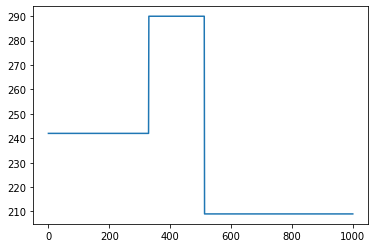

In [7]:
cx= space(x, cmax= c_max, cmin= c_min, dist_type= '3 parts')
maps.plot(x, cx)

In [8]:
# Source time function

def source_fn(f0, t0, fn):
    src  = np.zeros(nt + 1); 
    if fn== 'Gaussian':
        src  = -8. * (time - t0) * f0 * (np.exp(-1.0 * (4*f0) ** 2 * (time - t0) ** 2));
    elif fn== 'sin':
        src  = np.zeros(nt); 
        src[0:round(c0/f0+15)]= np.sin(2*3.14*f0*(time[0:round(c0/f0+15)]-t0));
    elif fn== 'delta':
        src  = np.zeros(nt); 
        src[round(t0/dt)]= 1;
    return src;


In [9]:
nx   = 1001        # number of grid points in x-direction
xmax = 1000        # physical domain (m)
dx   = xmax/(nx-1)  # grid point distance in x-direction
x    = dx* np.arange(nx); # spatial fabric


# CPL Stability Criterion
eps= 0.8; # <1
dt= eps/c_max*dx; # Now we don't have to worry about the stability of the solution
nt   = 500          # maximum number of time steps
time = np.linspace(0 * dt, nt * dt, nt); # time fabric


def generate_p(x, cx, p0):
  p= p0;
  P= np.zeros((nt, nx));
  pold= np.zeros_like(p);
  pnew= np.zeros_like(p);
  d2px = np.zeros(nx) # 2nd space derivative of p
  for it in range(nt):
      for i in range(1, nx - 1):
          d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2;

      pnew = 2 * p - pold + cx ** 2 * dt ** 2 * d2px;
      #pnew[isrc] = pnew[isrc] + src[it] / (dx) * dt ** 2;
      pold, p = p, pnew;
      P[it,:]= pnew;
  
  return P;



In [ ]:
p    = np.zeros(nx) # p at time n (now)
p[500]= 0.1;
p= generate_p(x, cx, p)[-1,:]
maps.plot(x, p)

In [12]:
def get_p0(nsrc, x):
  l= len(x);
  i_srcs= [random.randint(0, l-1) for i in range(0, nsrc)];
  srcs= 0.01* np.array([random.randint(0, 100) for i in range(0, nsrc)]);
  p= np.zeros_like(x);
  p[i_srcs]= srcs;
  return p;
  

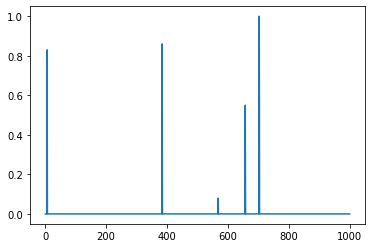

In [13]:
Pi= get_p0(5, x);
maps.plot(x, Pi)

In [14]:
sample= 1;
pred_t_len= 20; # we predict the next 20 time steps
each_samp= 25; # we pick 25 sample points from each (cx,p0) distribution
Px= np.zeros((each_samp*sample, nx));
Py= np.zeros((each_samp*sample, pred_t_len, nx));
C= np.zeros_like(Px);
for i in tqdm(range(0, sample)):
  dist_type= random.choice(['uniform', '2 parts', '3 parts', '4 parts']);
  cx= space(x, cmax= c_max, cmin= c_min, dist_type= dist_type);
  nsrc= random.randint(1, 10);
  p0= get_p0(nsrc, x);
  P_i= generate_p(x, cx, p0); # (nt, nx)= (500, 1001)
  pick_sample= [random.randint(0, 10) for i in range(0, each_samp)];
  px= P_i[pick_sample, :]; #(each_samp, nt) where we are picking each_samp (25) data points for the current cx, p0 distribution
  #px= np.expand_dims(px, axis= 1);
  py= np.array([P_i[pick_sample[i]+1: pick_sample[i]+pred_t_len+1, :] for i in range(0, len(pick_sample))]);
  #print(px.shape, py.shape);
  Px[each_samp*i:each_samp*(i+1),:]= px;
  Py[each_samp*i:each_samp*(i+1),:,:]= py;
  C[each_samp*i:each_samp*(i+1),:]= cx;
  #P[50*i:50*(i+1),:]= P_i[pick_sample, :];
  #if i%each_samp==0:
    #print("%d/%d" %(i*each_samp, sample*each_samp))


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


In [ ]:
np.savez_compressed("/content/drive/MyDrive/wave_sim/test_X_data.npz", X= Px)

In [ ]:
np.savez_compressed("/content/drive/MyDrive/wave_sim/test_C_data.npz", C= C)

In [ ]:
np.savez_compressed("/content/drive/MyDrive/wave_sim/test_Y_data.npz", Y= Py)